# Contest Parser v1
Goal is to return the following table
 
handle | rating | contestID | problemID | success 
--- | --- | --- | --- | --- | ---
handle0 | 1234 | 633 | A | 1
handle0 | 1234 | 633 | B | 1
handle0 | 1234 | 633 | C | 0


In [73]:
%matplotlib inline
import requests
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [150]:
contestID = 671
urlbase = 'http://codeforces.com/api/'
method = 'contest.standings'
maxcnt = 100000
#http://codeforces.com/api/contest.standings?contestId=566&from=1&count=5&showUnofficial=true
url = urlbase + method + '?contestId=' + str(contestID) + '&from=1&count=' + str(maxcnt) + '&showUnofficial=false'
r = requests.get(url).json()['result']
rows = r['rows']
problems = r['problems']
contest = r['contest']

## row objects
**keys:**
```
- successfulHackCount
- unsuccessfulHackCount
- rank
- penalty
- points
- party
- problemResults
```

Every entry appears to have the same keys
```python
test = rows[0].keys()
all([r.keys() == test for r in rows])
```

**problem results**
```
bestSubmissionTimeSeconds': 3624 <-- this field is absent if the user has points 0
points': 1330.0
rejectedAttemptCount': 0
type': u'FINAL' <-- All should be FINAL
```

```python
test = []
for r in rows:
    for rr in r['problemResults']:
        test.append(rr['type'])
all([t == 'FINAL' for t in test])
```
returns True

The following does not print anything:
```python
test = rows[0]['problemResults'][0].keys()
for r in rows:
    if not r['problemResults'][0].keys() == test and r['problemResults'][0]['points']!=0:
        print r['problemResults'][0]
```

In [151]:
# CHECK TO MAKE SURE THAT TEAMS ARE NOT ALLOWED!!!
for r in rows: # for each person
    if len(r['party']['members']) > 1:
        print "------------------NEED TO THROW ERROR HERE, CONTEST ALLOWS TEAMS"
        break

In [152]:
users = []
points = []
submitTime = []
#ranks = []
for r in rows:
    users.append(r['party']['members'][0]['handle'])
    
    #ranks.append(r['rank'])
    
    userpts = [0]*len(problems)
    usertime = [0]*len(problems)
    for i in range(len(problems)):
        userpts[i] = r['problemResults'][i]['points']
        try:
            usertime[i] = r['problemResults'][i]['bestSubmissionTimeSeconds']
        except:
            #usertime[i] = float('Inf')
            usertime[i] = -1
            
    points.append([1 if u > 0 else 0 for u in userpts])
    submitTime.append(usertime)

# Rating change parser


In [153]:
# Grab rating changes
method = 'contest.ratingChanges'
url = urlbase + method + '?contestId=' + str(contestID)
ratingchanges = requests.get(url).json()['result']
ratingdict = dict()
for r in ratingchanges:
    ratingdict[r['handle']] = r['oldRating']

# Create output df 

In [154]:
# start constructing dataframe
array_out = []
for i in range(len(users)): # for each user in the contest
    hdl = users[i]
    rating = ratingdict[hdl]
    for j, p in enumerate(problems): # for each problem in the contest, make a new row
        temp = dict.fromkeys(['handle', 'rating', 'contestID', 'problemID', 'success', 'submitTime'])
        temp['handle'] = hdl
        temp['contestID'] = contestID
        temp['problemID'] = p['index']
        temp['success'] = points[i][j]
        temp['submitTime'] = submitTime[i][j]
        temp['rating'] = rating
        array_out.append(temp)
    
output = pd.DataFrame.from_dict(array_out)

In [155]:
#output.loc[(output.problemID=='A') & (output.submitTime>0)]
output['submitTime'] = output.submitTime/60

# Visualization in sns 

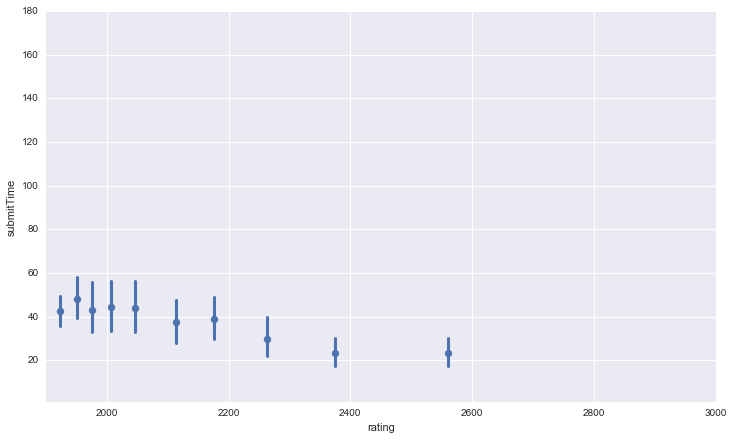

In [171]:
#fig=plt.figure(facecolor='white', figsize=(12, 8))
f, ax = plt.subplots(figsize=(12, 7), facecolor='white')
#ax.set(yscale="log")
ax.set_ylim(1,180)
#ax.set_xlim(800,2000)
ax.set_xlim(1900,3000)

dfa = output.loc[(output.problemID=='A') & (output.submitTime>0) & (output.rating !=1500)]
#A = sns.jointplot(x='rating', y='submitTime', data=dfa)
sns.regplot(x='rating', y='submitTime', data=dfa, x_bins=10, fit_reg=False)

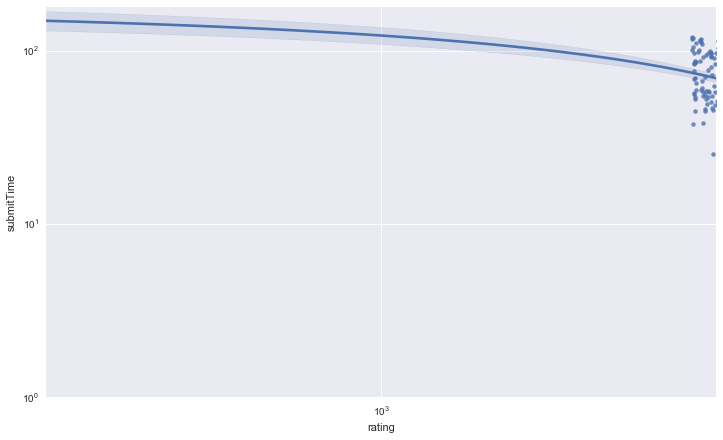

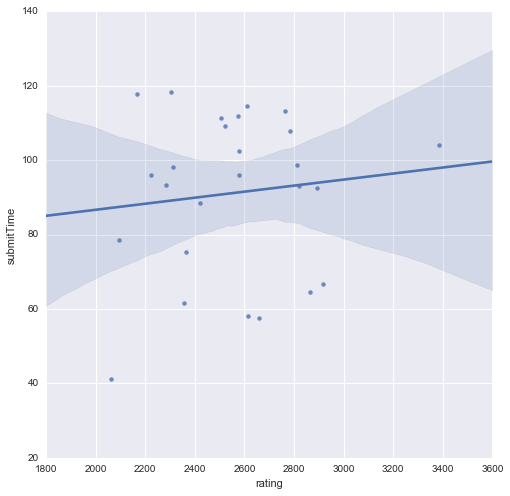

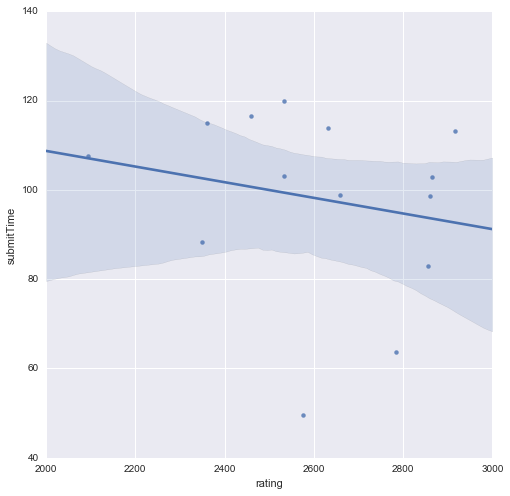

In [157]:
#fig=plt.figure(facecolor='white', figsize=(8, 8))
f, ax = plt.subplots(figsize=(12, 7), facecolor='white')
ax.set(xscale="log", yscale="log")
ax.set_ylim(1,180)
ax.set_xlim(500,2000)
dfb = output.loc[(output.problemID=='B') & (output.submitTime>0) & (output.rating !=1500)]
B = sns.regplot(x='rating', y='submitTime', data=dfb)

fig=plt.figure(facecolor='white', figsize=(8, 8))
dfc = output.loc[(output.problemID=='C') & (output.submitTime>0) & (output.rating !=1500)]
C = sns.regplot(x='rating', y='submitTime', data=dfc)

fig=plt.figure(facecolor='white', figsize=(8, 8))
dfd = output.loc[(output.problemID=='D') & (output.submitTime>0) & (output.rating !=1500)]
D = sns.regplot(x='rating', y='submitTime', data=dfd)